In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import warnings

In [63]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [64]:
# Custom helper functions
from helper_functions import evaluate_model, plot, plot_model_results

# Data: AMD Stock price

In [65]:
# Load dataset
loaded_data = pd.read_csv('amd.csv')

In [66]:
loaded_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,64.019997,46851800
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,64.660004,47477100
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,62.330002,46159500
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,63.959999,70161300
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,67.239998,69741300
...,...,...,...,...,...,...,...
311,2024-04-01,180.100006,187.240005,179.899994,183.339996,183.339996,74299900
312,2024-04-02,179.470001,180.100006,174.830002,178.699997,178.699997,61598800
313,2024-04-03,177.539993,182.050003,176.699997,180.770004,180.770004,49835100
314,2024-04-04,182.919998,183.020004,165.649994,165.830002,165.830002,88280000


In [67]:
loaded_data['date'] = pd.to_datetime(loaded_data['Date'])

In [68]:
# rename 'Adj Close' to 'price'
loaded_data.rename(columns={'Adj Close': 'price'}, inplace=True)

In [69]:
cols = ['date', 'price']
# cols = ['date', 'money']

# only keep the columns that we need
data = loaded_data[cols]
data = data.set_index(cols[0])

In [70]:
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max())

In [71]:
data = data.reindex(full_date_range)

In [72]:
# fill missing values using linear interpolation
data.interpolate(method='linear', inplace=True)
# data.fillna(method='ffill', inplace=True)
data.index.name = 'date'
data.reset_index(inplace=True)

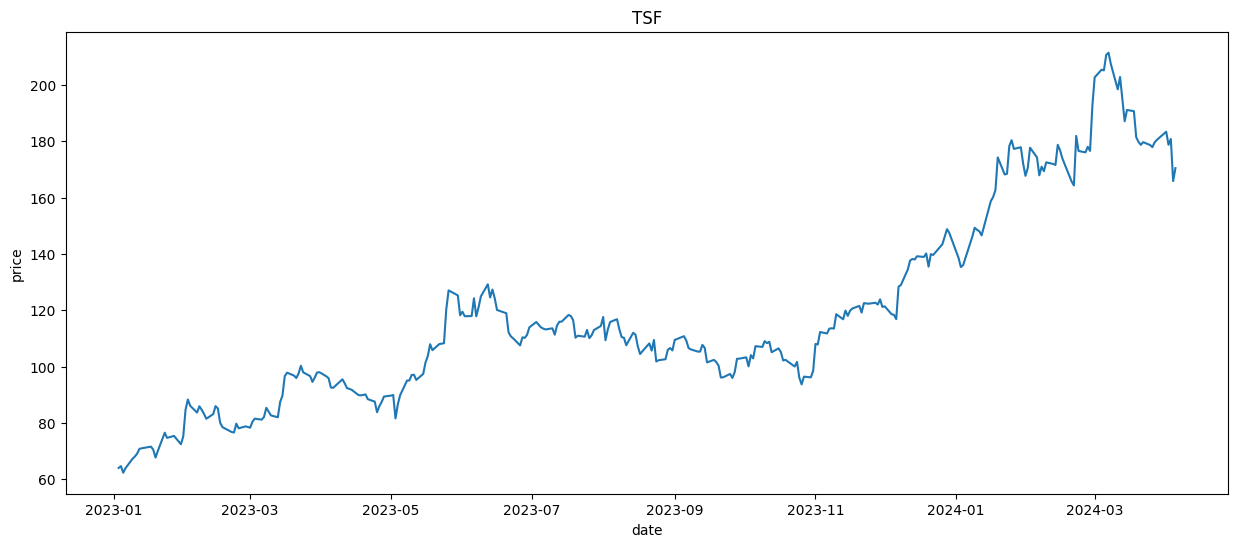

In [73]:
plot(data, cols)

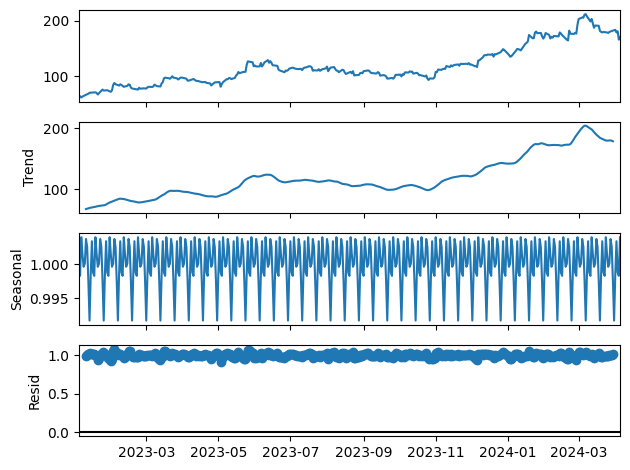

In [74]:
# seasonal decompose
result = seasonal_decompose(data.set_index('date'), model='multiplicative', period=12)
result.plot()
plt.show()

## Testing the need for differencing by using the Augmented Dickey-Fuller test

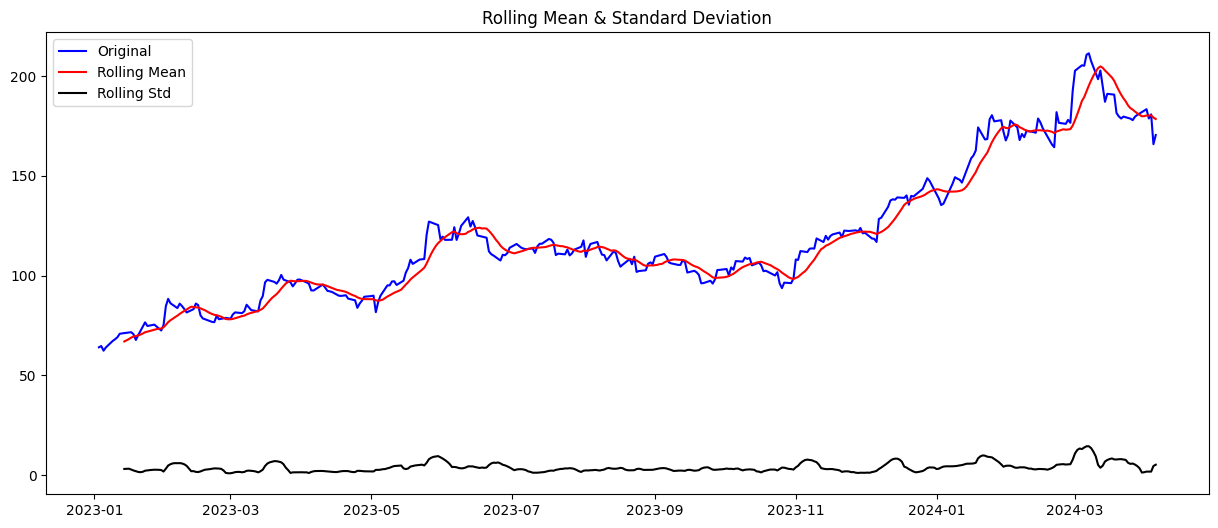

Results of Dickey-Fuller Test:
Test Statistic                  -0.979027
p-value                          0.760837
#Lags Used                       0.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [75]:
# stationary test
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data.set_index(cols[0])[cols[1]])

## Differencing because p-value is greater than 0.05 (time series is not stationary)

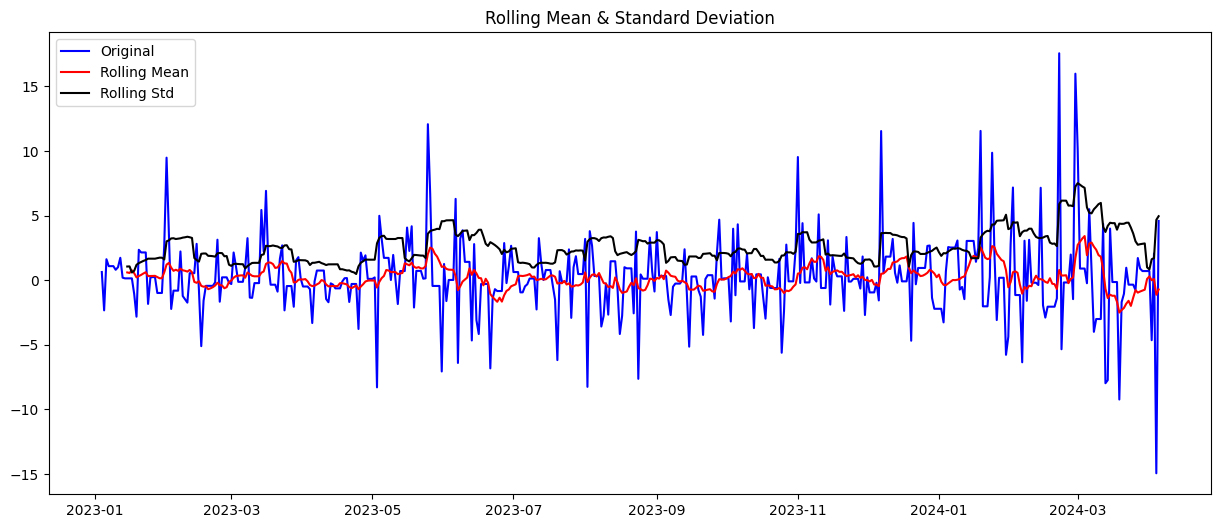

Results of Dickey-Fuller Test:
Test Statistic                 -20.772209
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    457.000000
Critical Value (1%)             -3.444740
Critical Value (5%)             -2.867885
Critical Value (10%)            -2.570150
dtype: float64


In [76]:
# the data is not stationary, we need to apply differencing
data['price_diff'] = data['price'] - data['price'].shift(1)
data.dropna(inplace=True)
test_stationarity(data.set_index('date')['price_diff'])
# cols = ['price_diff', cols[1]]

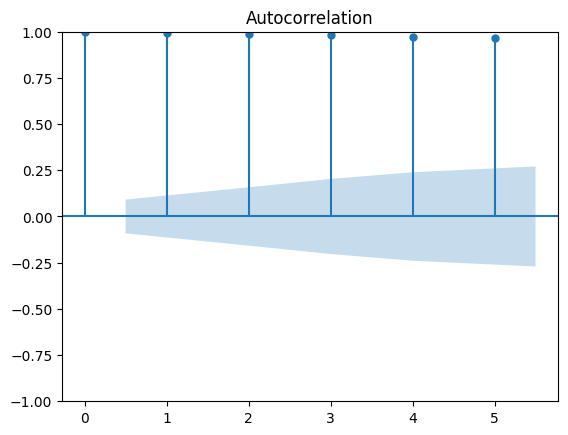

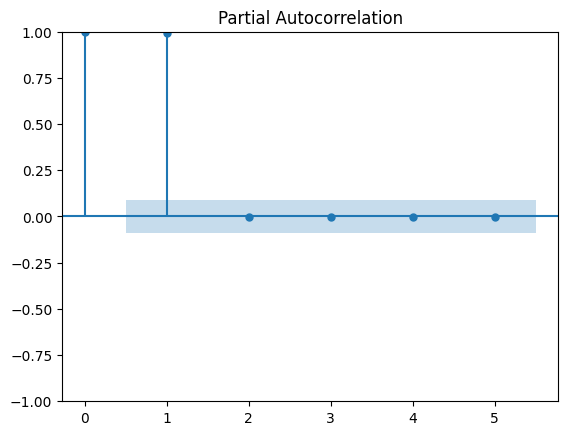

In [77]:
# generate ACF and PACF plots to determine the order of ARIMA model
col = cols[0]
plot_acf(data[col], lags=5)
plot_pacf(data[col], lags=5)
plt.show()

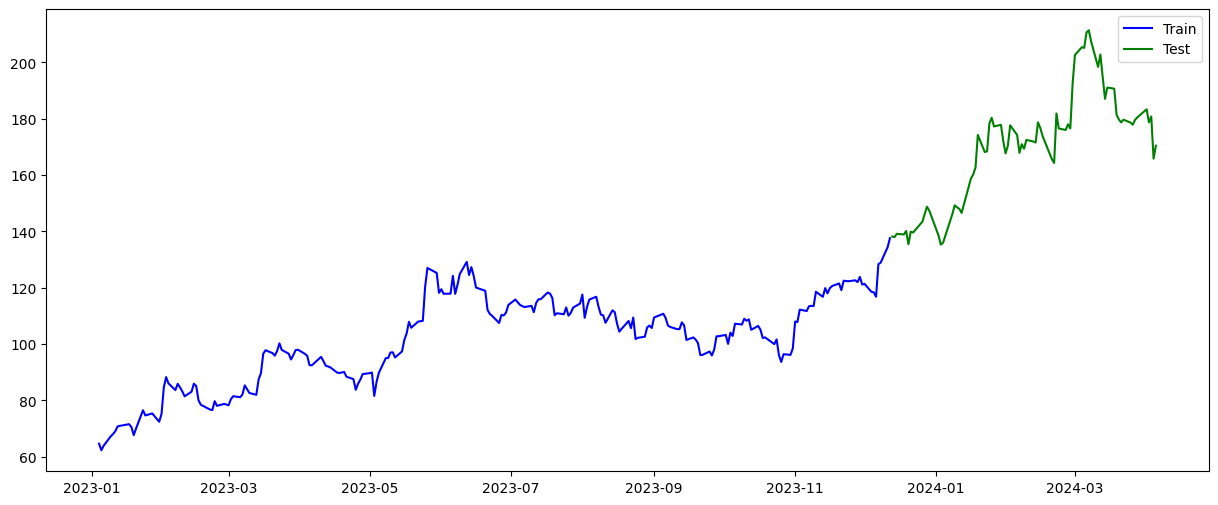

In [78]:
# train test split
train_size = int(len(data) * 0.75)
train, test = data[:train_size], data[train_size:]

# plot train and test data (with different colors - blue for train and green for test)
plt.figure(figsize=(15, 6))
plt.plot(train[cols[0]], train[cols[1]], label='Train', color='blue')
plt.plot(test[cols[0]], test[cols[1]], label='Test', color='green')
plt.legend(loc='best')
plt.show()

# Exponential Smoothing

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


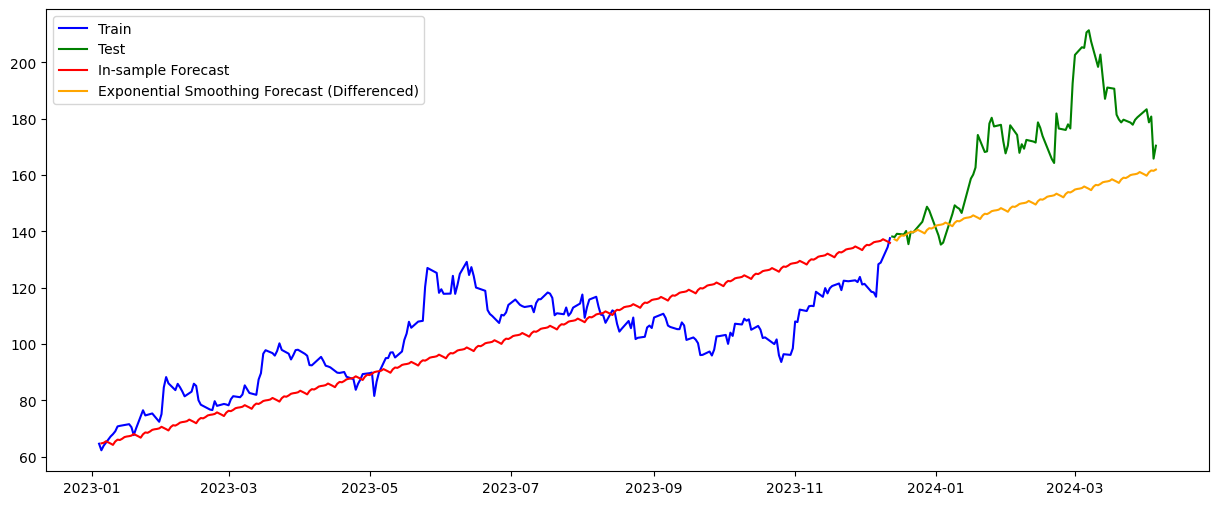

Train Scores:

RMSE: 13.954135177365904
MAE: 11.530049557916206
R2: 0.22299872096033757
MAPE: 0.11069369406017017

Test Scores:

RMSE: 24.71496369876507
MAE: 20.2273562622047
R2: -0.5159926943235795
MAPE: 0.11145838496218322


In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

_test = test[cols[1]][1:]
_train = train[cols[1]][1:]

# Exponential Smoothing with differenced data
model_es = ExponentialSmoothing(
    train_diff.dropna(), seasonal="add", seasonal_periods=12
).fit()

# Forecast differenced data for the length of the test series
forecast_es_diff = model_es.forecast(len(test_diff))

# Reverting differencing for forecast
# We need to add the last observed value from the training set (train[cols[1]].iloc[-1])
forecast_es = forecast_es_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_es_diff = model_es.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_es = forecast_train_es_diff.cumsum() + train[cols[1]].iloc[0]

# Plot the model results
plot_model_results(
    train=train,
    test=test,
    label="Exponential Smoothing Forecast (Differenced)",
    forecast=forecast_es,
    forecast_train=forecast_train_es,
    cols=cols,
    differencing=1
)

# print train and test scores
print('Train Scores:\n')
rmse_es, mae_es, r2_es, mape_es = evaluate_model(_train, forecast_train_es)
print(f'RMSE: {rmse_es}')
print(f'MAE: {mae_es}')
print(f'R2: {r2_es}')
print(f'MAPE: {mape_es}')

print('\nTest Scores:\n')
rmse_es, mae_es, r2_es, mape_es = evaluate_model(_test, forecast_es)
print(f'RMSE: {rmse_es}')
print(f'MAE: {mae_es}')
print(f'R2: {r2_es}')
print(f'MAPE: {mape_es}')

# AR: Autoregression

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


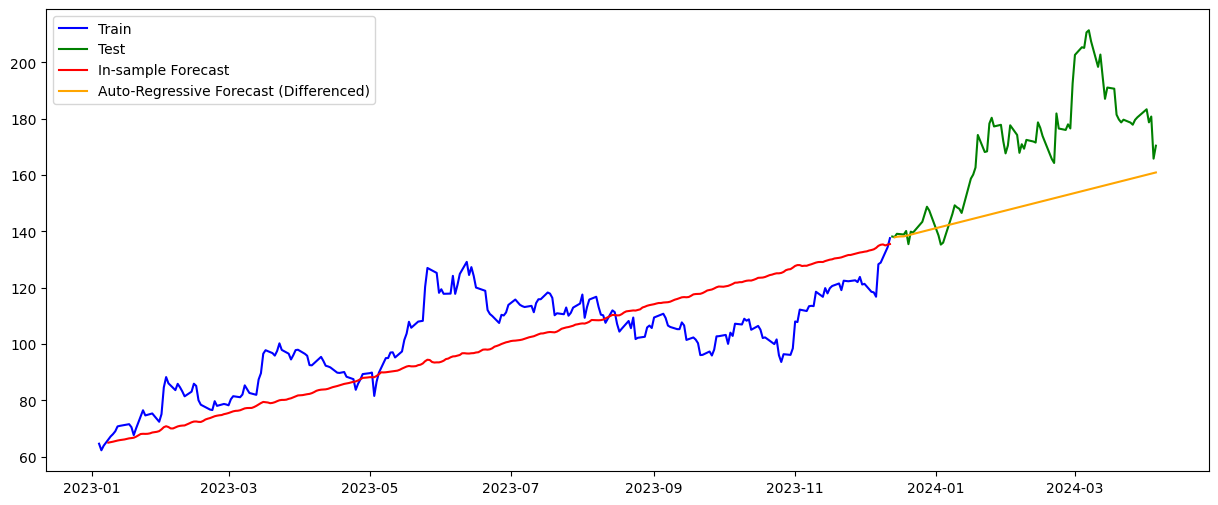

Train Scores:

RMSE: 15.120237360410608
MAE: 12.11214731734215
R2: 0.08770961046031678
MAPE: 0.11990803097418451

Test Scores:

RMSE: 25.30822220634511
MAE: 20.766099885533848
R2: -0.5896460396720624
MAPE: 0.11441932637867279


In [80]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# Auto-Regressive Model with differenced data
model_ar = AutoReg(train_diff, lags=5).fit()
forecast_ar_diff = model_ar.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_ar = forecast_ar_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_ar_diff = model_ar.predict(
    start=train_diff.index[0], end=train_diff.index[-1]
)
forecast_train_ar = forecast_train_ar_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="Auto-Regressive Forecast (Differenced)",
    forecast=forecast_ar,
    forecast_train=forecast_train_ar,
    cols=cols,
    differencing=1,
)


# print train and test scores
print("Train Scores:\n")
rmse_ar, mae_ar, r2_ar, mape_ar = evaluate_model(_train, forecast_train_ar)
print(f"RMSE: {rmse_ar}")
print(f"MAE: {mae_ar}")
print(f"R2: {r2_ar}")
print(f"MAPE: {mape_ar}")

print("\nTest Scores:\n")
rmse_ar, mae_ar, r2_ar, mape_ar = evaluate_model(_test, forecast_ar)
print(f"RMSE: {rmse_ar}")
print(f"MAE: {mae_ar}")
print(f"R2: {r2_ar}")
print(f"MAPE: {mape_ar}")

# MA: Moving Average

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


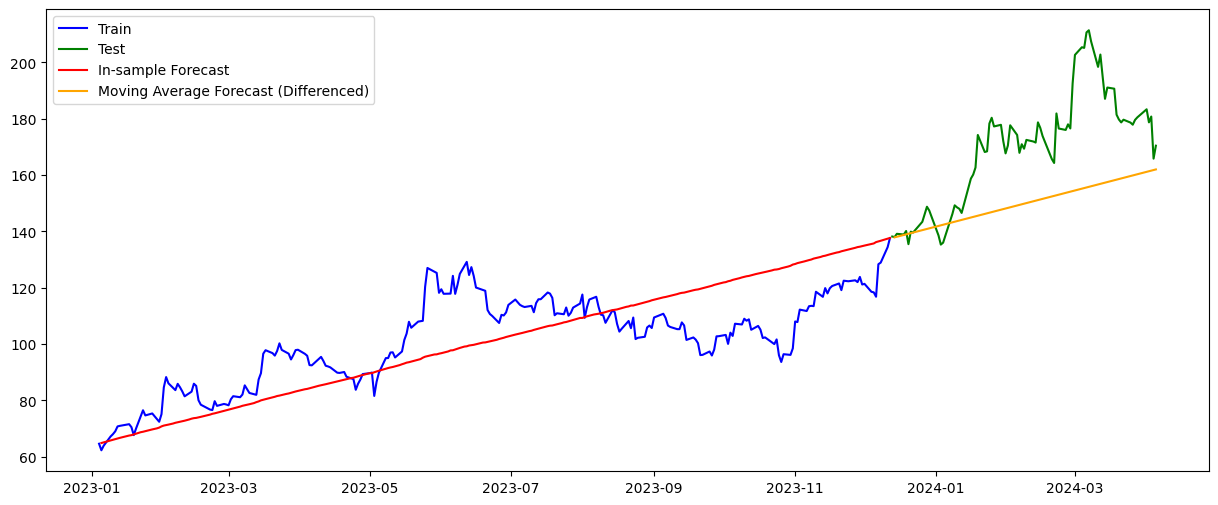

Train Scores:

RMSE: 13.609502378976673
MAE: 11.135643667396792
R2: 0.26090481356122
MAPE: 0.1065823267150664

Test Scores:

RMSE: 24.624069432026207
MAE: 20.0769819563025
R2: -0.5048624607155985
MAPE: 0.11050717607812209


In [81]:
from statsmodels.tsa.arima.model import ARIMA

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# Fit an MA(1) model (ARIMA(0, 1, 1)) with differenced data
model_ma = ARIMA(train_diff, order=(0, 0, 1)).fit()
forecast_ma_diff = model_ma.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_ma = forecast_ma_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_ma_diff = model_ma.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_ma = forecast_train_ma_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="Moving Average Forecast (Differenced)",
    forecast=forecast_ma,
    forecast_train=forecast_train_ma,
    cols=cols,
    differencing=1
)

# print train and test scores
print("Train Scores:\n")
rmse_ma, mae_ma, r2_ma, mape_ma = evaluate_model(_train, forecast_train_ma)
print(f"RMSE: {rmse_ma}")
print(f"MAE: {mae_ma}")
print(f"R2: {r2_ma}")
print(f"MAPE: {mape_ma}")

print("\nTest Scores:\n")
rmse_ma, mae_ma, r2_ma, mape_ma = evaluate_model(_test, forecast_ma)
print(f"RMSE: {rmse_ma}")
print(f"MAE: {mae_ma}")
print(f"R2: {r2_ma}")
print(f"MAPE: {mape_ma}")

# ARIMA

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


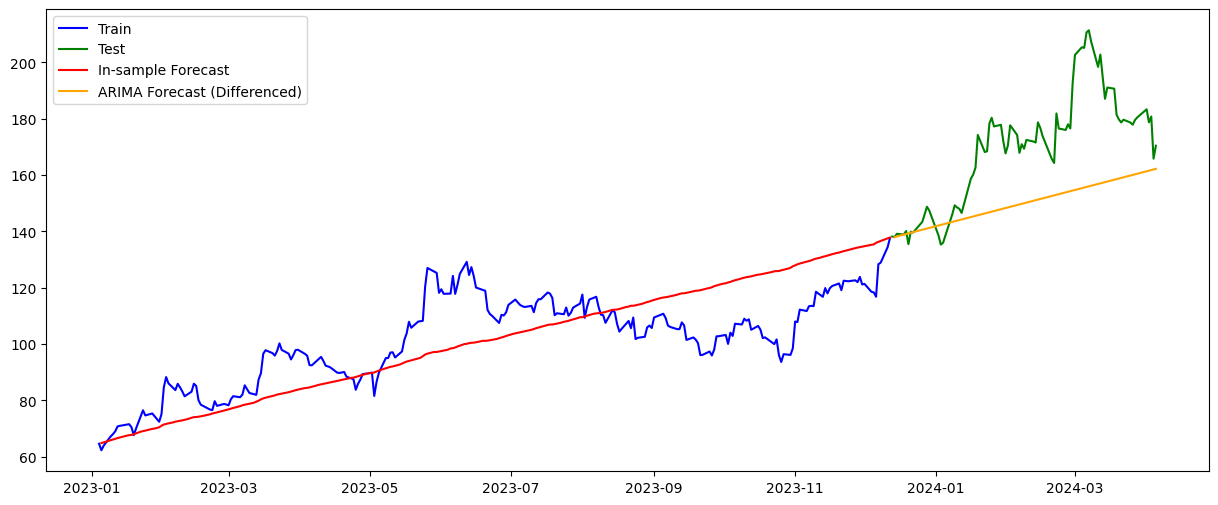

Train Scores:

RMSE: 13.258378249302561
MAE: 10.838708300455298
R2: 0.2985500446946131
MAPE: 0.10371324762482098

Test Scores:

RMSE: 24.48414156778403
MAE: 19.930671454155227
R2: -0.48780809887231946
MAPE: 0.10966908956918532


In [82]:
from statsmodels.tsa.arima.model import ARIMA

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# ARIMA Model with differenced data
model_arima = ARIMA(train_diff, order=(1, 0, 1)).fit()
forecast_arima_diff = model_arima.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_arima = forecast_arima_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_arima_diff = model_arima.predict(
    start=train_diff.index[0], end=train_diff.index[-1]
)
forecast_train_arima = forecast_train_arima_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="ARIMA Forecast (Differenced)",
    forecast=forecast_arima,
    forecast_train=forecast_train_arima,
    cols=cols,
    differencing=1,
)


# print train and test scores
print("Train Scores:\n")
rmse_arima, mae_arima, r2_arima, mape_arima = evaluate_model(_train, forecast_train_arima)
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")
print(f"R2: {r2_arima}")
print(f"MAPE: {mape_arima}")

print("\nTest Scores:\n")
rmse_arima, mae_arima, r2_arima, mape_arima = evaluate_model(_test, forecast_arima)
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")
print(f"R2: {r2_arima}")
print(f"MAPE: {mape_arima}")

# SARIMA

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# parameter tuning for p, d, q
best_rmse = np.inf
best_order = None

for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = SARIMAX(train[cols[1]], order=(p, d, q)).fit()
                forecast = model.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test[cols[1]], forecast))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
            except:
                pass

print(f"Best Order: {best_order}")
# Best Order: (2, 2, 1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05049D+00    |proj g|=  9.76996D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.770D-10   6.050D+00
  F =   6.0504908056648912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.7

 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      7      1     0     0   1.363D-06   2.289D+00
  F =   2.2893085312844224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61151D+00    |proj g|=  1.74735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     32      1     0     0   5.799D-05   2.290D+00
  F =   2.2898588981573842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16321D+02    |proj g|=  1.82271D+03

At iterate    5    f=  1.11836D+01    |proj g|=  1.56085D+01

At iterate   10    f=  3.07656D+00    |proj g|=  6.18459D-01

At iterate   15    f=  2.42186D+00    |proj g|=  4.73494D-02

At iter

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.



At iterate   20    f=  2.32222D+00    |proj g|=  7.82276D-03

At iterate   25    f=  2.30789D+00    |proj g|=  5.86766D-03

At iterate   30    f=  2.30703D+00    |proj g|=  4.21448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     36      1     0     0   5.014D-06   2.307D+00
  F =   2.3070103617329623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29034D+00    |proj g|=  7.87996D-05

       

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/yousha


At iterate   15    f=  2.28992D+00    |proj g|=  2.63701D-04

At iterate   20    f=  2.28984D+00    |proj g|=  5.55271D-04

At iterate   25    f=  2.28983D+00    |proj g|=  7.66133D-04

At iterate   30    f=  2.28983D+00    |proj g|=  6.76757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     35      1     0     0   7.694D-05   2.290D+00
  F =   2.2898275600195630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.



At iterate   15    f=  2.63742D+00    |proj g|=  2.05178D-02

At iterate   20    f=  2.34031D+00    |proj g|=  1.93728D-02

At iterate   25    f=  2.31010D+00    |proj g|=  1.55393D-03

At iterate   30    f=  2.30805D+00    |proj g|=  7.11144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     43      1     0     0   5.273D-07   2.308D+00
  F =   2.3080432460577112     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.



At iterate   40    f=  2.30827D+00    |proj g|=  8.43601D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     45      1     0     0   8.436D-06   2.308D+00
  F =   2.3082715161156244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09743D+02    |proj g|=  1.88101D+03

At iterate    5    f=  4.02498D+00    |proj g|=  3.68699D+00

At iterate   10    f=  2.45441D+00    |proj g|=  1.46097D-01

At iter

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28934D+00    |proj g|=  2.58356D-03

At iterate    5    f=  2.28932D+00    |proj g|=  7.36094D-04

At iterate   10    f=  2.28930D+00    |proj g|=  1.29778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   9.260D-06   2.289D+00
  F =   2.2892979106022038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
 This problem is unconstrained.



At iterate    5    f=  2.41391D+00    |proj g|=  1.59681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.597D-05   2.414D+00
  F =   2.4139086396452005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35649D+00    |proj g|=  8.57467D-02

At iterate    5    f=  2.30087D+00    |proj g|=  3.67171D-02

At iterate   10    f=  2.29059D+00    |proj g|=  3.67309D-03

At iter

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46022D+00    |proj g|=  1.01647D-01


 This problem is unconstrained.



At iterate    5    f=  2.29271D+00    |proj g|=  2.48235D-02

At iterate   10    f=  2.27230D+00    |proj g|=  1.20811D-02

At iterate   15    f=  2.26936D+00    |proj g|=  9.21630D-04

At iterate   20    f=  2.26928D+00    |proj g|=  2.09593D-04

At iterate   25    f=  2.26925D+00    |proj g|=  7.07534D-03

At iterate   30    f=  2.26855D+00    |proj g|=  2.15823D-02

At iterate   35    f=  2.26813D+00    |proj g|=  4.22897D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   4.246D-06   2.268D+00
  F =   2.2681308481812450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


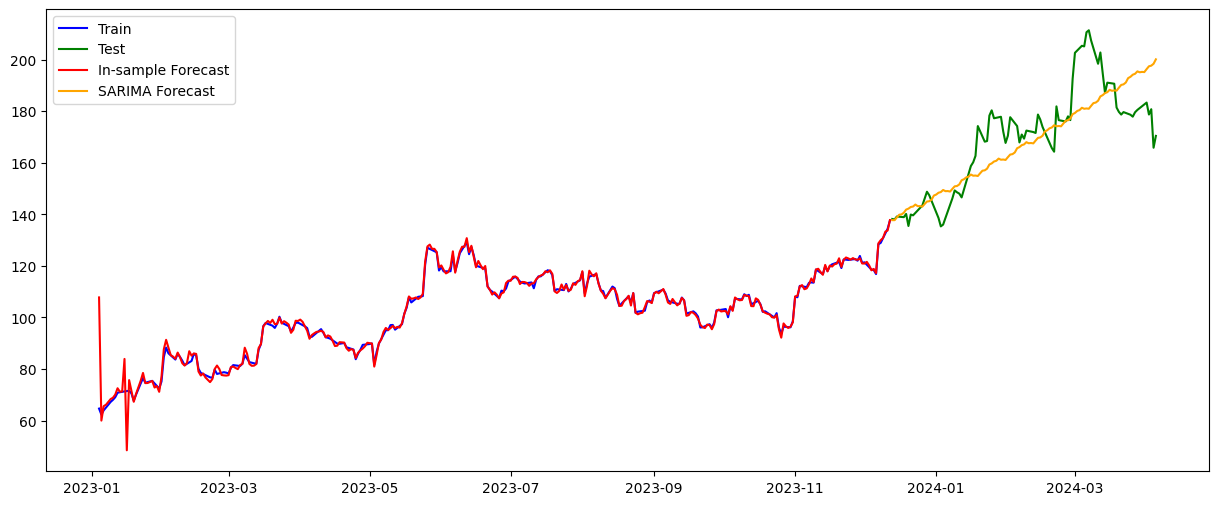

Train Scores:

RMSE: 2.876080711402581
MAE: 0.9090516519376511
R2: 0.9674111688588249
MAPE: 0.01052655534658922

Test Scores:

RMSE: 12.182236853229837
MAE: 9.315996319647406
R2: 0.636166364634042
MAPE: 0.05259435337676755


In [84]:
# SARIMA Model
model_sarima = SARIMAX(
    train[cols[1]], order=best_order, seasonal_order=(1, 1, 1, 12)
).fit()
forecast_sarima = model_sarima.forecast(steps=len(test))
# predict in sample (train data)
forecast_sarima_train = model_sarima.predict(
    start=train.index.min(), end=train.index.max()
)

plot_model_results(
    train=train,
    test=test,
    label="SARIMA Forecast",
    forecast=forecast_sarima,
    forecast_train=forecast_sarima_train,
    cols=cols,
)


# print train and test scores
print("Train Scores:\n")
rmse_sarima, mae_sarima, r2_sarima, mape_sarima = evaluate_model(
    # _train, forecast_sarima_train
    train[cols[1]],
    forecast_sarima_train,
)
print(f"RMSE: {rmse_sarima}")
print(f"MAE: {mae_sarima}")
print(f"R2: {r2_sarima}")
print(f"MAPE: {mape_sarima}")

print("\nTest Scores:\n")
rmse_sarima, mae_sarima, r2_sarima, mape_sarima = evaluate_model(
    test[cols[1]], forecast_sarima
)
print(f"RMSE: {rmse_sarima}")
print(f"MAE: {mae_sarima}")
print(f"R2: {r2_sarima}")
print(f"MAPE: {mape_sarima}")

In [85]:
# Define the metrics for each model
metrics = {
    "Model": ["ES", "AR", "MA", "ARIMA", "SARIMA"],
    "RMSE": [rmse_es, rmse_ar, rmse_ma, rmse_arima, rmse_sarima],
    "MAE": [mae_es, mae_ar, mae_ma, mae_arima, mae_sarima],
    "R2": [r2_es, r2_ar, r2_ma, r2_arima, r2_sarima],
    "MAPE": [mape_es, mape_ar, mape_ma, mape_arima, mape_sarima]
}

# Create DataFrame
scores_df = pd.DataFrame(metrics)
scores_df

,Model,RMSE,MAE,R2,MAPE
0,ES,24.714964,20.227356,-0.515993,0.111458
1,AR,25.308222,20.766100,-0.589646,0.114419
2,MA,24.624069,20.076982,-0.504862,0.110507
3,ARIMA,24.484142,19.930671,-0.487808,0.109669
4,SARIMA,12.182237,9.315996,0.636166,0.052594


## Observations

### SARIMA model had the best performance with the lowest RMSE and providing the best looking fit.
### AR, MA and ARIMA had very similar results for this data, the results were very smooth
### ES also performed well but was less smooth than AR,MA and ARIMA